In [173]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Examine series of models trained with 03_cvae_multi script

In [174]:
import os
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt
from bioreaction.misc.misc import flatten_listlike
import seaborn as sns
from evoscaper.model.evaluation import calc_prompt_adherence
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation

from evoscaper.utils.preprocess import make_datetime_str

sns.set_context("paper")


In [175]:
top_write_dir = os.path.join('data', '08_cvae_examine_multi', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

In [176]:
top_write_dir = os.path.join('data', '08_cvae_examine_multi', make_datetime_str())
os.makedirs(top_write_dir, exist_ok=True)

fn_hpos = os.path.join('data', 'cvae_multi', '2025_03_03__21_33_13', 'df_hpos.json')
df_hpos = pd.read_json(fn_hpos)

# dir_source = os.path.join('data', '03_cvae_multi', '2025_02_12__11_48_22')
# dirs_source = [os.path.join('data', '03_cvae_multi', k) for k in ['2025_02_08__18_09_53', '2025_02_08__22_15_29', '2025_02_11__13_49_15', '2025_02_11__21_13_15', '2025_02_13__13_38_43']]
# df_hpos = pd.DataFrame()
# for d in dirs_source:
#     fn_hpos = os.path.join(d, 'df_hpos_main.json')
#     df_hpos_i = pd.read_json(fn_hpos)
#     df_hpos = pd.concat([df_hpos, df_hpos_i[df_hpos_i['R2_train'] != 'TO_BE_RECORDED']], axis=0)
df_hpos = df_hpos[df_hpos['R2_train'] != 'TO_BE_RECORDED']
df_hpos = df_hpos.sort_index()
df_hpos = df_hpos[df_hpos['R2_train'].apply(lambda x: x > 0 if type(x) != str else True)]
df_hpos['mutual_information_conditionality'] = df_hpos['mutual_information_conditionality'].apply(lambda x: np.mean(x) if type(x) == list else x)


In [177]:
output_idx = -1
perc_recall=0.01
df_hpos['precision'] = np.nan
df_hpos['recall'] = np.nan
df_hpos['f1'] = np.nan
for i, r in df_hpos.iterrows():
    curr_dir = os.path.dirname(r['filename_saved_model'])
    fn_sample = os.path.join(curr_dir, 'sampled_cond.npy')
    fn_analytics = os.path.join(curr_dir, 'analytics.json')
    if r['R2_train'] > 0.8 and os.path.exists(fn_sample) and os.path.exists(fn_analytics):
        sampled_cond = np.load(fn_sample)
        analytics = load_json_as_dict(fn_analytics)
        analytics['adaptation'] = calculate_adaptation(
            np.array(analytics['sensitivity']), np.array(analytics['precision']))
        a = np.concatenate([np.array(analytics[k])[..., output_idx][:, None] for k in r['objective_col']], axis=-1).reshape(*sampled_cond.shape)
        precision, recall, f1 = calc_prompt_adherence(sampled_cond, a, perc_recall=perc_recall)
        df_hpos.loc[i, 'precision'] = precision.mean()
        df_hpos.loc[i, 'recall'] = recall.mean()
        df_hpos.loc[i, 'f1'] = f1.mean()



In [178]:
df_hpos.loc[~df_hpos['use_kl_div'], 'kl_weight'] = np.nan
df_hpos['threshold_early_val_acc'] = df_hpos['threshold_early_val_acc'].apply(np.float32)

for c in df_hpos.columns:
    if df_hpos[c].dtype == bool:
        df_hpos[c] = df_hpos[c].astype(str)
        

In [179]:
df_hpos['kl_weight'] = df_hpos['kl_weight'] * 1e4
df_hpos.rename(columns={'kl_weight': 'kl_weight (x10e-4)'}, inplace=True)
# df_hpos.rename(columns={'kl_weight x10e-4': 'kl_weight (x10e-4)'}, inplace=True)
# df_hpos['total_ds_max'] = np.log10(df_hpos['total_ds_max'])
# df_hpos.rename(columns={'total_ds_max': 'Log Total ds'}, inplace=True)
df_hpos['Log Total data'] = np.log10(df_hpos['total_ds_max'] )
df_hpos['Dataset seed'] = df_hpos['seed_dataset']
df_hpos['KL divergence loss'] = df_hpos['use_kl_div']
cols_exclude_renamed = ['total_ds_max', 'seed_dataset', 'use_kl_div']

In [180]:
if 'kl_div_ave' in df_hpos.columns:
    df_hpos['kl_div_max'] = df_hpos['kl_div_ave'].apply(lambda x: np.nanmax(list(x.values())))

cols_out_verify = ['precision', 'recall', 'f1']
cols_outmetric = ['R2_train', 'kl_div_max'] + [c for c in cols_out_verify if (~df_hpos[c].isna().sum() > 0)]
cols_latent_stats = ['conditional_entropy', 'condition_entropy_std', 'cluster_separation', 'variance_ratio', 'nn_accuracy']
cols_output = cols_outmetric + [i + '_' + k for k in cols_latent_stats for i in flatten_listlike(df_hpos['objective_col'].apply(tuple).unique())]
cols_output = [c for c in cols_output if c in df_hpos.columns]

cols_exclude = ['R2_test', 'mutual_information_conditionality', 'objective_col', 'output_species', 'signal_species', 'filenames_train_config', 'kl_div_ave']
df_hpos = df_hpos[(df_hpos != 'TO_BE_RECORDED').all(axis=1)]
cols_input = [c for c in df_hpos.columns if (c not in cols_output) and (c not in cols_exclude)]
df_hpos['Objective'] = df_hpos['objective_col'].apply(lambda x: ',\n'.join(x))
# for c in df_hpos.columns:
#     if type(df_hpos[c].iloc[0]) == list: 
#         df_hpos[c] = df_hpos[c].apply(lambda x: ',\n'.join(x) if (x is not None) and (type(x[0]) == str) else np.array(x))
cols_meta = ['filename_saved_model', 'run_successful', 'info_early_stop', 'error_msg', 'total_ds', 'n_batches', 'n_layers_enc', 'n_layers_dec']
cols_exclude = cols_exclude + cols_meta + cols_exclude_renamed
cols_varying = [c for c in cols_input if (c not in cols_exclude) and (df_hpos[c].nunique() > 1)]

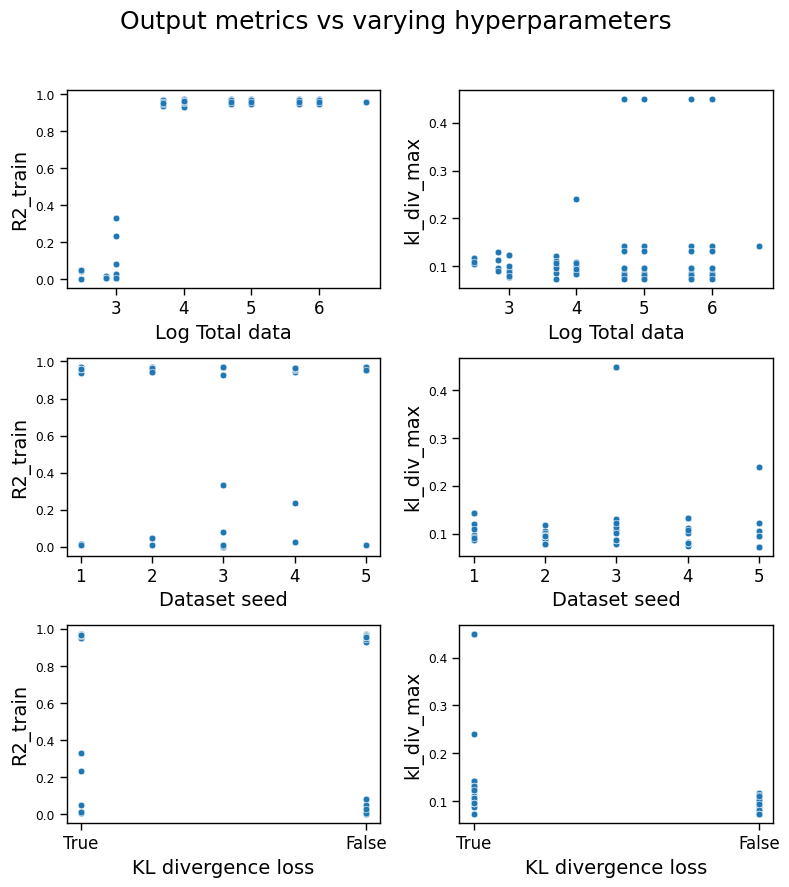

In [181]:
nrows = len(cols_varying)
ncols = len(cols_outmetric)
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))

for i, k in enumerate(cols_varying):
    for j, kj in enumerate(cols_outmetric):
        sns.scatterplot(data=df_hpos, x=k, y=kj, ax=axes[i, j])
        if k == 'learning_rate':
            axes[i, j].set_xscale('log')
        axes[i, j].tick_params(axis='x', labelsize=12)
        axes[i, j].set_xlabel(k, fontsize=14)
        axes[i, j].set_ylabel(kj, fontsize=14)
plt.suptitle(f'Output metrics vs varying hyperparameters', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(os.path.join(top_write_dir, 'varying_vs_output_metrics.png'), dpi=300, bbox_inches='tight', transparent=True)


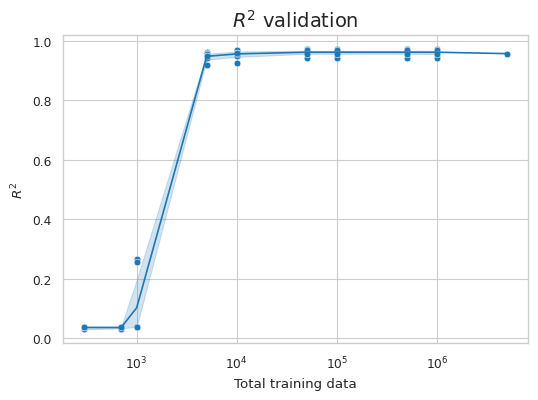

In [202]:
if ('Log Total data' in cols_varying) or ('total_ds_max' in cols_varying):
    sns.set_context("paper")
    sns.set_style("whitegrid")
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df_hpos, x='total_ds_max', y='R2_test')
    sns.lineplot(data=df_hpos, x='total_ds_max', y='R2_test')
    plt.xscale('log')
    plt.xlabel('Total training data') #, fontsize=12)
    plt.ylabel(r'$R^2$') #, fontsize=12)
    plt.title(r'$R^2$ validation', fontsize=14)
    plt.savefig(os.path.join(top_write_dir, 'r2_vs_total_data.png'), dpi=300, bbox_inches='tight', transparent=True)
    

In [182]:
hpos_to_vary_together = load_json_as_dict('configs/cvae_multi/scan_datasize.json')['hpos_to_vary_together']
# hpos_to_vary_together = [{
#     'Objective': [('adaptation',), ('Log sensitivity',), ('Log sensitivity', 'Log precision')],
#     'prep_y_categorical': [False, True],
#     'use_kl_div': [True],
#     # 'kl_weight': [5e-5, 1e-4, 2.5e-4, 4e-4, 5e-4],
#     'kl_weight (x10e-4)': np.array([5e-5, 1e-4, 2.5e-4, 4e-4, 5e-4]) * 1e3,
#     'threshold_early_val_acc': [0.995, 0.98, 0.96, 0.9],
# },
#     {
#     'use_contrastive_loss': [True],
#     'temperature': [0.1, 0.5, 1, 1.5, 2, 4, 8],
#     'threshold_similarity': [0.95, 0.9, 0.7, 0.5, 0.3, 0.1],
#     'power_factor_distance': [3, 4],
#     'threshold_early_val_acc': [0.995, 0.9]
# }]

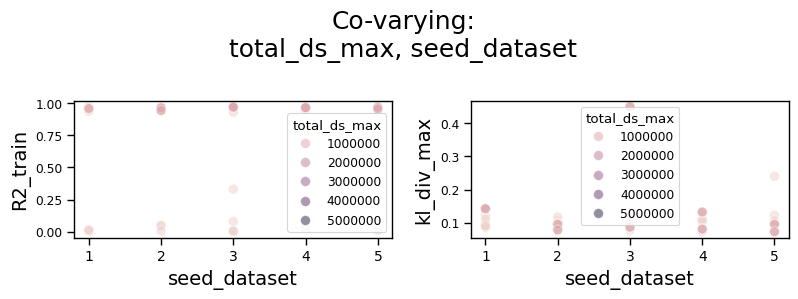

In [183]:
for h in hpos_to_vary_together:
    h_keys = [c for c in h.keys() if df_hpos[c].nunique() > 1]
    combinations = sorted(set([tuple(sorted([i, j])) for i, j in itertools.combinations(h_keys, 2)]))
    ncols = len(cols_outmetric)
    nrows = len(combinations)
    if len(combinations) > 0:
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
        if nrows == 1:
            axes = axes[None, :]
        for i, (k1, k2) in enumerate(combinations):
            for j, kj in enumerate(cols_outmetric):
                if df_hpos[k1].dtype == object and (df_hpos[k2].iloc[0] not in ['True', 'False']) and (k2 != 'kl_weight (x10e-4)'):
                    f = sns.barplot
                    # f = sns.violinplot
                    kwargs = {'palette': 'viridis'}
                else:
                    f = sns.scatterplot
                    kwargs = {'s': 50, 'alpha': 0.5}
                    if df_hpos[k2].dtype in [float, np.float32, np.float64]: #  k2 == 'threshold_early_val_acc':
                        kwargs.update({'palette': 'viridis'})
                f(data=df_hpos, x=k1, y=kj, hue=k2, ax=axes[i, j], 
                #   legend=(j == (ncols - 1)), 
                  **kwargs)
                axes[i, j].tick_params(axis='x', labelsize=10)
                axes[i, j].set_xlabel(k1, fontsize=14)
                axes[i, j].set_ylabel(kj, fontsize=14)
        plt.suptitle('Co-varying:\n' + ', '.join(h_keys), fontsize=18)
        plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(os.path.join(top_write_dir, 'varying_confounding.png'), dpi=300, bbox_inches='tight', transparent=True)


# Zoom in on KL weight 

In [184]:
choose_kl = [0.5]
choose_objective = ['Log sensitivity', ('Log sensitivity,\nLog precision')]

filt_kl = df_hpos['kl_weight (x10e-4)'].isin(choose_kl) & df_hpos['Objective'].isin(
    choose_objective) & df_hpos['run_successful'] & df_hpos['filename_saved_model'].apply(
        lambda x: os.path.exists(os.path.join(os.path.dirname(x), 'sampled_cond.npy'))) & df_hpos['filename_saved_model'].apply(lambda x: os.path.exists(os.path.join(os.path.dirname(x), 'analytics.json')))


df_train_tables = {}
for k in df_hpos[filt_kl]['filenames_train_table'].unique():
    fn = r['filenames_train_table'].replace('notebooks/', '')
    df_train_table = pd.read_json(fn) if fn.endswith(
        '.json') else pd.read_csv(fn)
    df_train_table['Log sensitivity'] = np.log(
        df_train_table['sensitivity'])
    df_train_table['Log precision'] = np.log(
        df_train_table['precision'])
    df_train_tables[k] = df_train_table

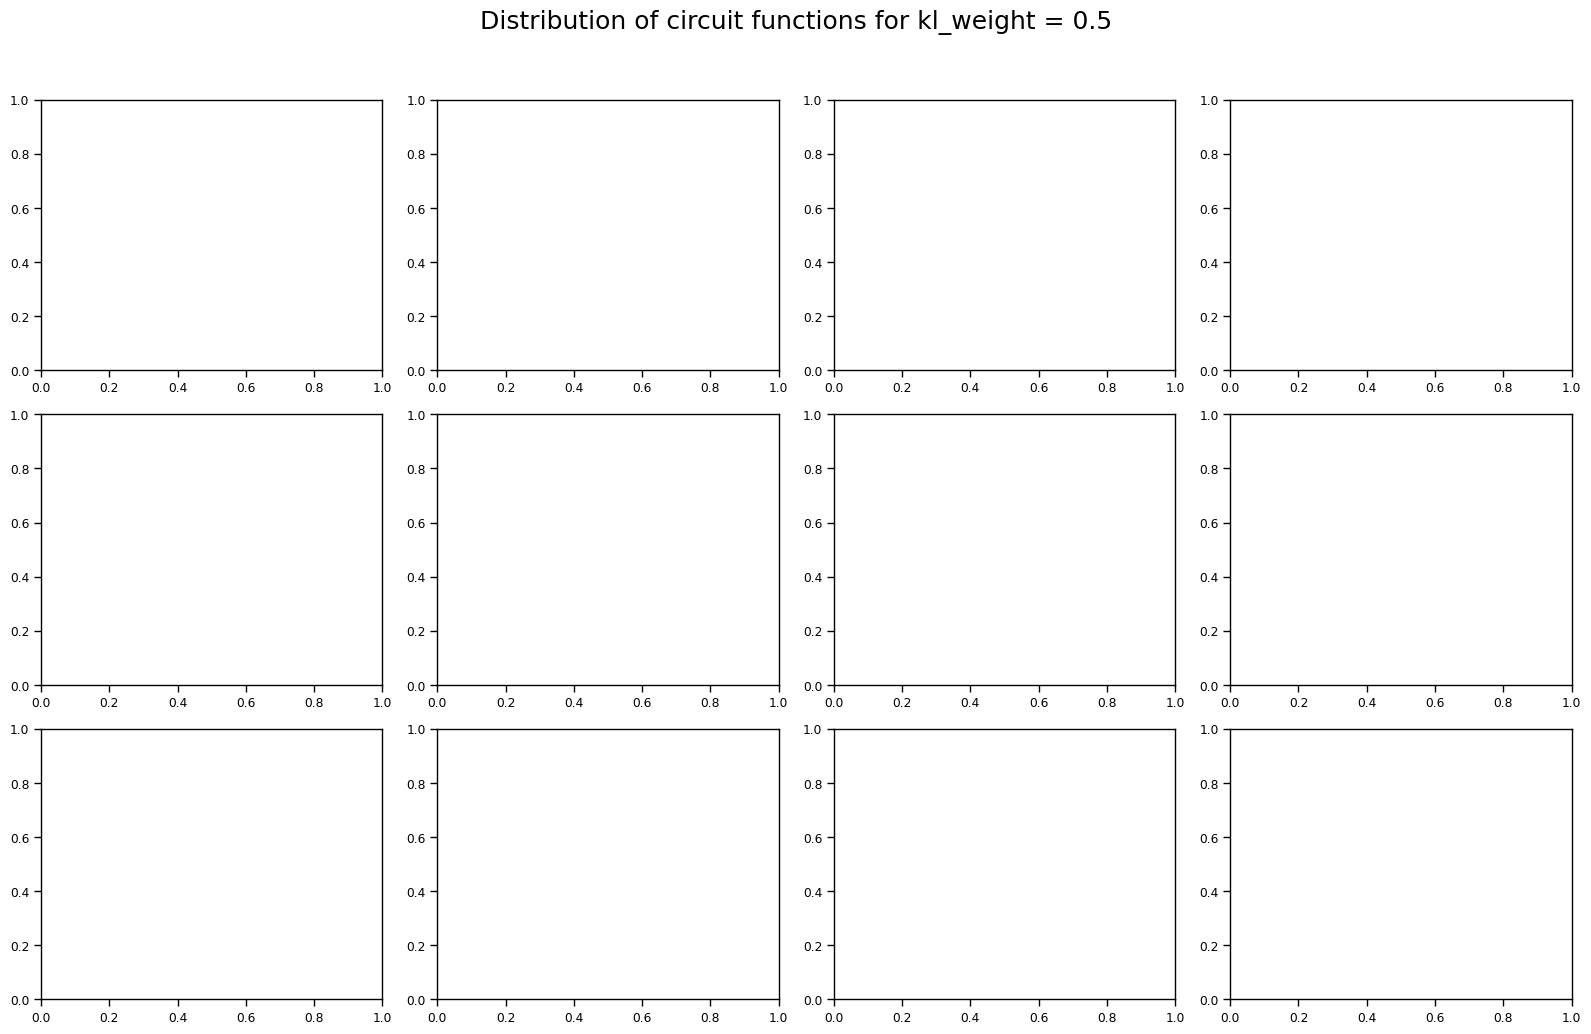

In [185]:
def get_og_sample_cond(sampled_cond, df_train_tables, r):
    data = df_train_tables[r['filenames_train_table']]
    analytic = data[(data['sample_name'] == 'RNA_2') & (data['response_time'] <
                                                        r['filt_response_time_perc_max']*data['response_time'].max())][r['objective_col']]
    analytic = np.where(np.isinf(analytic), np.nan, analytic)

    a_range = (np.nanmax(analytic) - np.nanmin(analytic))
    a_min = np.nanmin(analytic) - a_range * 0.1
    a_max = np.nanmax(analytic) + a_range * 0.1

    cond = np.interp(sampled_cond, (sampled_cond.min(),
                     sampled_cond.max()), (a_min, a_max))
    return cond


nrows = 3  # int(np.ceil(np.sqrt(len(df_hpos[filt_kl]))))
ncols = 4  # int(np.ceil(np.sqrt(len(df_hpos[filt_kl]))))
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 3.5*nrows))
for i, (i_df, r) in enumerate(df_hpos[filt_kl].iterrows()):
    curr_dir = os.path.dirname(r['filename_saved_model'])
    fn_sample = os.path.join(curr_dir, 'sampled_cond.npy')
    fn_analytics = os.path.join(curr_dir, 'analytics.json')

    sampled_cond = np.load(fn_sample)
    sampled_cond = sampled_cond.reshape(np.prod(sampled_cond.shape[:-1]), -1)
    analytics = load_json_as_dict(fn_analytics)
    a = np.concatenate([np.array(analytics[k])[..., output_idx][:, None]
                       for k in r['objective_col']], axis=-1).reshape(*sampled_cond.shape)
    a_resp = np.array(
        analytics['response_time'])[..., output_idx]
    idxs_good = np.where(
        a_resp < r['filt_response_time_perc_max']*a_resp.max())[0]
    cond = get_og_sample_cond(sampled_cond, df_train_tables, r)

    sns.kdeplot(x=a[idxs_good].flatten(), hue=cond[idxs_good].flatten().astype(
        np.float32), palette='viridis', ax=axs.flat[i])
    axs.flat[i].set_title(
        f'Precision = {r["precision"]:.2f}, Recall = {r["recall"]:.2f}, {"continuous" if r["prep_y_categorical"] != "True" else "categorical"}')
    axs.flat[i].set_xlabel(", ".join(r["objective_col"]))

plt.suptitle(
    'Distribution of circuit functions for kl_weight = 0.5', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(top_write_dir, 'distribution_circuit_functions.png'),
            dpi=300, bbox_inches='tight', transparent=True)

In [186]:
if len(df_hpos[filt_kl]):
    obj_cols = flatten_listlike(list([df_hpos[df_hpos['Objective'] == o]['objective_col'].iloc[0] for o in df_hpos['Objective'].unique()]))
    # obj_cols = flatten_listlike(df_hpos['objective_col'].apply(tuple).unique())
    fig, axs = plt.subplots(1, len(obj_cols), figsize=(4*len(obj_cols), 3*1))
    for i, obj_col in enumerate(obj_cols):
        ax = axs.flat[i]
        d = df_train_tables[r['filenames_train_table']]
        if 'adaptation' not in d:
            d['adaptation'] = calculate_adaptation(
                np.array(d['sensitivity']), np.array(d['precision']))
        d = d[(d['sample_name'] == 'RNA_2') & (d['response_time'] < r['filt_response_time_perc_max']*d['response_time'].max())]
        if type(obj_col) != str:
            # sns.kdeplot(d[obj_col].to_numpy().flatten(), ax=ax)
            for o in obj_col:
                sns.kdeplot(d, x=o, ax=ax, label=o)
                plt.legend()
        else:
            sns.kdeplot(d, x=obj_col, ax=ax)
        ax.set_title(obj_col)
        
    plt.suptitle('Training data', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(top_write_dir, 'distribution_training_data.png'), dpi=300, bbox_inches='tight', transparent=True)
